## Домашнее задание №4. GAN

### Creating config object (argparse workaround)

In [1]:
student_name = "Ruslan Sungatullin" # Введите свое имя и фамилию

В рамках этого домашнего задания мы разберем архитектуру простейшего GAN для генерации картинок одежды и попробуем ее немного модифицировать

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [4]:
# Конфигурация
num_epochs = 3
noise_size = 50
print_freq = 100
batch_size = 16

# Как мы будем помечать истинные и сгенерированные изображения
real_label = 1
fake_label = 0

# Шум, из которого генератор будет делать картинки
# Заготовка - новые можно сделать с помощью .normal_()
noise = torch.FloatTensor(batch_size, noise_size)

In [5]:
# Отображает 16 картинок из pic в сетке 4x4
def show_pictures(pic):
    plt.figure(figsize=(6, 7))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(pic[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.axis('off')

**Загружаем данные для работы**

In [6]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True,
                                          transform=torchvision.transforms.ToTensor(), download=True)

In [7]:
dataloader = DataLoader(train, batch_size, shuffle=True)
for batch, _ in dataloader: # Жертвуем 1 батчом из первой итерации для обучения - ничего страшного
    break

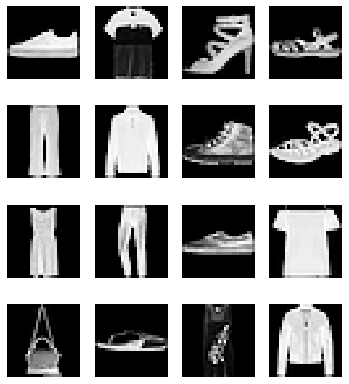

In [8]:
show_pictures(batch.reshape(-1, 28, 28))

**Реализация GAN**

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()).to(device)
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid()).to(device)
    def forward(self, x):
        return self.model(x)

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [11]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss().to(device)

In [12]:
ERRD_x = np.zeros(num_epochs)
ERRD_z = np.zeros(num_epochs)
ERRG = np.zeros(num_epochs)
N = len(dataloader)

for epoch in range(num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        label = torch.FloatTensor(batch_size).to(device) # место для меток
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        output = discriminator(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        noise = noise.to(device)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

/home/ruslan/.local/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:1 Iter: 100 errD_x: 0.17 errD_z: 0.16 errG: 1.94
Epoch:1 Iter: 200 errD_x: 0.23 errD_z: 0.11 errG: 2.50
Epoch:1 Iter: 300 errD_x: 0.18 errD_z: 0.15 errG: 2.24
Epoch:1 Iter: 400 errD_x: 0.06 errD_z: 0.11 errG: 2.56
Epoch:1 Iter: 500 errD_x: 0.17 errD_z: 0.11 errG: 2.58
Epoch:1 Iter: 600 errD_x: 0.12 errD_z: 0.10 errG: 2.68
Epoch:1 Iter: 700 errD_x: 0.21 errD_z: 0.15 errG: 2.54
Epoch:1 Iter: 800 errD_x: 0.05 errD_z: 0.27 errG: 1.97
Epoch:1 Iter: 900 errD_x: 0.34 errD_z: 0.24 errG: 1.67
Epoch:1 Iter: 1000 errD_x: 0.16 errD_z: 0.20 errG: 1.77
Epoch:1 Iter: 1100 errD_x: 0.17 errD_z: 0.23 errG: 1.80
Epoch:1 Iter: 1200 errD_x: 0.24 errD_z: 0.31 errG: 1.55
Epoch:1 Iter: 1300 errD_x: 0.28 errD_z: 0.23 errG: 1.76
Epoch:1 Iter: 1400 errD_x: 0.18 errD_z: 0.31 errG: 1.87
Epoch:1 Iter: 1500 errD_x: 0.06 errD_z: 0.40 errG: 1.42
Epoch:1 Iter: 1600 errD_x: 0.23 errD_z: 0.11 errG: 2.46
Epoch:1 Iter: 1700 errD_x: 0.41 errD_z: 0.21 errG: 2.07
Epoch:1 Iter: 1800 errD_x: 0.09 errD_z: 0.31 errG: 2.06
E

torch.Size([16, 784])


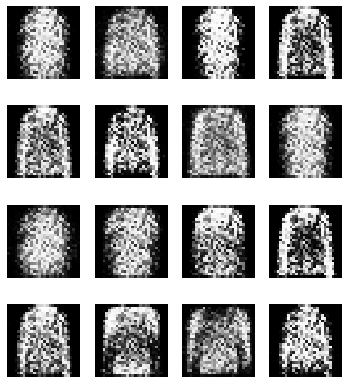

In [13]:
# Смотрим на результат
noise.data.normal_(0, 1)
fake = generator(noise)
print(fake.shape)

show_pictures(fake)

### Задание
В каждом пункте постройте графики функций потерь.  

1) Посмотрите на реализацию GAN выше. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками.  
  (Опционально) Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

In [14]:
img1 = fake[3]
img2 = fake[5]

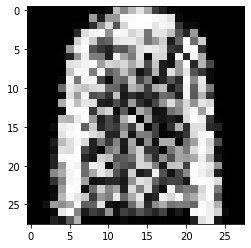

In [15]:
plt.imshow(img1.detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)

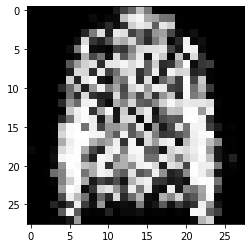

In [16]:
plt.imshow(img2.detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)

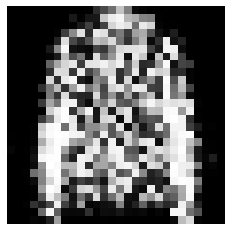

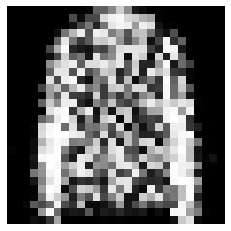

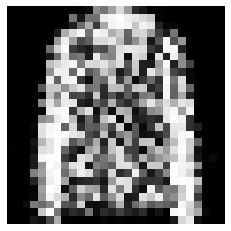

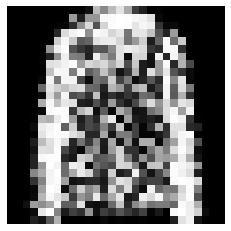

In [17]:
for a in [0.1, 0.4, 0.7, 0.99]:
    img = a*img1+(1-a)*img2
    plt.imshow(img.detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
    plt.show()

Получилось нечто несуразное, что весьма логично для gan, для vae ситуация должна быть лучше.

2) Поменяйте реализацию, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [10]:
# Конфигурация
num_epochs = 3
noise_size = 256
print_freq = 100
batch_size = 16

# Как мы будем помечать истинные и сгенерированные изображения
real_label = 1
fake_label = 0

In [11]:
class GeneratorLSGAN(nn.Module):
    def __init__(self, nz=256, ngf=64, nChannels=1):
        super(GeneratorLSGAN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels = nz,
                out_channels = ngf*4,
                kernel_size = 7,
                stride = 1,
                padding = 0,
                bias = False
            ),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels = ngf*4,
                out_channels = ngf*2,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True)
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels = ngf*2,
                out_channels = nChannels,
                kernel_size =4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.Tanh()
        )
            
        self.model = nn.Sequential(
            self.layer1,
            self.layer2,
            self.layer3
        )
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out
    


In [22]:
class DiscriminatorLSGAN(nn.Module):
    def __init__(self, ndf=64, nChannels=1):
        super(DiscriminatorLSGAN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels = nChannels,
                out_channels = ndf,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels = ndf,
                out_channels = ndf*2,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(
                in_channels = ndf*2,
                out_channels = ndf*4,
                kernel_size = 4,
                stride = 2,
                padding = 2,
                bias = False
            ),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(
                in_channels = ndf*4,
                out_channels = 1,
                kernel_size = 4,
                stride = 1,
                padding = 0,
                bias = False
            )
        )
        
        self.model = nn.Sequential(
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out.view(-1,1)

In [23]:
generatorLSGAN = GeneratorLSGAN().to(device)
discriminatorLSGAN = DiscriminatorLSGAN().to(device)
optim_G = optim.Adam(params=generatorLSGAN.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminatorLSGAN.parameters(), lr=0.0001)

criterion = nn.BCELoss().to(device)

In [24]:
ERRD_x = np.zeros(num_epochs)
ERRD_z = np.zeros(num_epochs)
ERRG = np.zeros(num_epochs)
N = len(dataloader)

for epoch in range(num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        discriminatorLSGAN.zero_grad()
        label = torch.FloatTensor(batch_size).to(device) # место для меток
        
        # real
        label.data.fill_(real_label)
        input_data = images.to(device)
        output = discriminatorLSGAN(input_data)
        errD_real = 0.5 * torch.mean((output-label)**2) # criterion(output, label)
        errD_real.backward()
        ERRD_x[epoch] += errD_real.item()
        
        # fake 
        latent_noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
        fake = generatorLSGAN(latent_noise)
        label.data.fill_(fake_label)
        output = discriminatorLSGAN(fake.detach())
        errD_fake = 0.5 * torch.mean((output-label)**2) 
        errD_fake.backward()
        ERRD_z[epoch] += errD_fake.item()
        
        optim_D.step()
        generatorLSGAN.zero_grad()
        label.data.fill_(real_label)
        output = discriminatorLSGAN(fake)
        errG = 0.5 * torch.mean((output - label)**2)
        errG.backward()
        ERRG[epoch] += errG.item()
        
        optim_G.step()
        
        if (iteration+1) % print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_real.item(),
                                                                                            errD_fake.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.01 errD_z: 0.00 errG: 0.51
Epoch:1 Iter: 200 errD_x: 0.00 errD_z: 0.00 errG: 0.59
Epoch:1 Iter: 300 errD_x: 0.00 errD_z: 0.00 errG: 0.54
Epoch:1 Iter: 400 errD_x: 0.00 errD_z: 0.01 errG: 0.47
Epoch:1 Iter: 500 errD_x: 0.00 errD_z: 0.00 errG: 0.57
Epoch:1 Iter: 600 errD_x: 0.00 errD_z: 0.01 errG: 0.52
Epoch:1 Iter: 700 errD_x: 0.00 errD_z: 0.00 errG: 0.66
Epoch:1 Iter: 800 errD_x: 0.00 errD_z: 0.00 errG: 0.56
Epoch:1 Iter: 900 errD_x: 0.00 errD_z: 0.02 errG: 0.47
Epoch:1 Iter: 1000 errD_x: 0.01 errD_z: 0.02 errG: 0.68
Epoch:1 Iter: 1100 errD_x: 0.00 errD_z: 0.01 errG: 0.60
Epoch:1 Iter: 1200 errD_x: 0.01 errD_z: 0.01 errG: 0.62
Epoch:1 Iter: 1300 errD_x: 0.00 errD_z: 0.01 errG: 0.46
Epoch:1 Iter: 1400 errD_x: 0.00 errD_z: 0.00 errG: 0.59
Epoch:1 Iter: 1500 errD_x: 0.01 errD_z: 0.01 errG: 0.39
Epoch:1 Iter: 1600 errD_x: 0.03 errD_z: 0.01 errG: 0.48
Epoch:1 Iter: 1700 errD_x: 0.01 errD_z: 0.01 errG: 0.42
Epoch:1 Iter: 1800 errD_x: 0.01 errD_z: 0.01 errG: 0.45
E

torch.Size([16, 1, 28, 28])


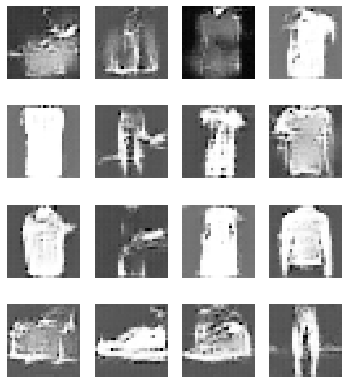

In [25]:
# Смотрим на результат
noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
fake = generatorLSGAN(noise.detach())
print(fake.shape)

show_pictures(fake)

Сейчас уже мы значительно лучше генерируем картинки.

Попробуем теперь обучить на большем числе эпох с большим размером батча и большим числом параметров.

In [30]:
# Конфигурация
num_epochs = 10
noise_size = 256
print_freq = 100
batch_size = 64

dataloader = DataLoader(train, batch_size, shuffle=True)
for batch, _ in dataloader: # Жертвуем 1 батчом из первой итерации для обучения - ничего страшного
    break
    
# Как мы будем помечать истинные и сгенерированные изображения
real_label = 1
fake_label = 0

generatorLSGAN2 = GeneratorLSGAN(nz=noise_size, ngf=128).to(device)
discriminatorLSGAN2 = DiscriminatorLSGAN(ndf=128).to(device)
optim_G = optim.Adam(params=generatorLSGAN2.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminatorLSGAN2.parameters(), lr=0.0001)


ERRD_x = np.zeros(num_epochs)
ERRD_z = np.zeros(num_epochs)
ERRG = np.zeros(num_epochs)
N = len(dataloader)

for epoch in range(num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        discriminatorLSGAN2.zero_grad()
        label = torch.FloatTensor(batch_size).to(device) # место для меток
        
        # real
        label.data.fill_(real_label)
        input_data = images.to(device)
        output = discriminatorLSGAN2(input_data)
        errD_real = 0.5 * torch.mean((output-label)**2) # criterion(output, label)
        errD_real.backward()
        ERRD_x[epoch] += errD_real.item()
        
        # fake 
        latent_noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
        fake = generatorLSGAN2(latent_noise)
        label.data.fill_(fake_label)
        output = discriminatorLSGAN2(fake.detach())
        errD_fake = 0.5 * torch.mean((output-label)**2) 
        errD_fake.backward()
        ERRD_z[epoch] += errD_fake.item()
        
        optim_D.step()
        generatorLSGAN2.zero_grad()
        label.data.fill_(real_label)
        output = discriminatorLSGAN2(fake)
        errG = 0.5 * torch.mean((output - label)**2)
        errG.backward()
        ERRG[epoch] += errG.item()
        
        optim_G.step()
        
        if (iteration+1) % print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_real.item(),
                                                                                            errD_fake.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.01 errD_z: 0.03 errG: 0.71
Epoch:1 Iter: 200 errD_x: 0.00 errD_z: 0.00 errG: 0.46
Epoch:1 Iter: 300 errD_x: 0.00 errD_z: 0.00 errG: 0.56
Epoch:1 Iter: 400 errD_x: 0.00 errD_z: 0.00 errG: 0.51
Epoch:1 Iter: 500 errD_x: 0.00 errD_z: 0.00 errG: 0.55
Epoch:1 Iter: 600 errD_x: 0.00 errD_z: 0.00 errG: 0.49
Epoch:1 Iter: 700 errD_x: 0.00 errD_z: 0.00 errG: 0.54
Epoch:1 Iter: 800 errD_x: 0.00 errD_z: 0.00 errG: 0.52
Epoch:1 Iter: 900 errD_x: 0.00 errD_z: 0.00 errG: 0.48
Epoch:2 Iter: 100 errD_x: 0.00 errD_z: 0.00 errG: 0.50
Epoch:2 Iter: 200 errD_x: 0.00 errD_z: 0.00 errG: 0.52
Epoch:2 Iter: 300 errD_x: 0.00 errD_z: 0.00 errG: 0.57
Epoch:2 Iter: 400 errD_x: 0.00 errD_z: 0.00 errG: 0.52
Epoch:2 Iter: 500 errD_x: 0.00 errD_z: 0.00 errG: 0.45
Epoch:2 Iter: 600 errD_x: 0.00 errD_z: 0.00 errG: 0.50
Epoch:2 Iter: 700 errD_x: 0.00 errD_z: 0.00 errG: 0.51
Epoch:2 Iter: 800 errD_x: 0.00 errD_z: 0.00 errG: 0.45
Epoch:2 Iter: 900 errD_x: 0.00 errD_z: 0.00 errG: 0.50
Epoch:3 It

torch.Size([64, 1, 28, 28])


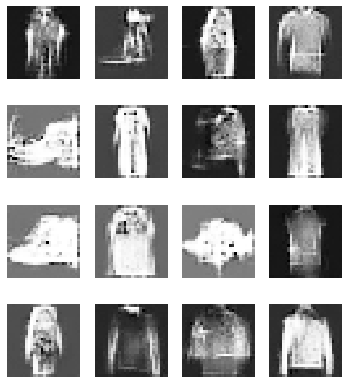

In [31]:
# Смотрим на результат
noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
fake = generatorLSGAN2(noise.detach())
print(fake.shape)

show_pictures(fake)

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

In [91]:
class GeneratorCGAN(nn.Module):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        self.label_embedding = nn.Embedding(10, 10)
        self.model = nn.Sequential( 
            nn.Linear(noise_size+10, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()).to(device)
        
    def forward(self, x, labels):
        x = torch.cat((self.label_embedding(labels), x.view(x.size(0), -1)), -1)
        return self.model(x)
    
class DiscriminatorCGAN(nn.Module):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        
        self.label_embedding = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(28*28+10, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.Dropout(),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512), 
            nn.Dropout(),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1)).to(device)
    def forward(self, x, labels):
        x = torch.cat((self.label_embedding(labels), x.view(x.size(0), -1)), -1)
        return self.model(x)

In [92]:
# Конфигурация
num_epochs = 3
noise_size = 50
print_freq = 100
batch_size = 16

# Как мы будем помечать истинные и сгенерированные изображения
real_label = 1
fake_label = 0

# Шум, из которого генератор будет делать картинки
# Заготовка - новые можно сделать с помощью .normal_()
noise = torch.FloatTensor(batch_size, noise_size)

dataloader = DataLoader(train, batch_size, shuffle=True)
for batch, _ in dataloader: # Жертвуем 1 батчом из первой итерации для обучения - ничего страшного
    break
    

In [93]:
generatorCGAN = GeneratorCGAN().to(device)
discriminatorCGAN = DiscriminatorCGAN().to(device)
optim_G = optim.Adam(params=generatorCGAN.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminatorCGAN.parameters(), lr=0.0001)

criterion = nn.MSELoss().to(device)

In [100]:
ERRD_x = np.zeros(num_epochs)
ERRD_z = np.zeros(num_epochs)
ERRG = np.zeros(num_epochs)
N = len(dataloader)

for epoch in range(num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        cat = cat.to(device)
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)
        
        
        generatorCGAN.zero_grad()
        noise.data.normal_(0, 1)
        noise = noise.to(device)
        gen_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
        gen_imgs = generatorCGAN(noise.detach(), gen_labels)
        output = discriminatorCGAN(gen_imgs, gen_labels)
        errG = criterion(output, valid)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        discriminatorCGAN.zero_grad()
        input_data = images.view(images.shape[0], -1).to(device)
        validity_real = discriminatorCGAN(input_data, cat)
        real_loss = criterion(validity_real, valid)
        errD_x = criterion(validity_real, valid)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        validity_fake = discriminatorCGAN(gen_imgs.detach(), gen_labels)
        errD_z = criterion(validity_fake, fake)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        optim_D.step()
        
        if (iteration+1) % print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.25 errD_z: 0.05 errG: 0.75
Epoch:1 Iter: 200 errD_x: 0.08 errD_z: 0.07 errG: 0.96
Epoch:1 Iter: 300 errD_x: 0.10 errD_z: 0.04 errG: 0.95
Epoch:1 Iter: 400 errD_x: 0.10 errD_z: 0.06 errG: 0.72
Epoch:1 Iter: 500 errD_x: 0.06 errD_z: 0.02 errG: 0.96
Epoch:1 Iter: 600 errD_x: 0.07 errD_z: 0.02 errG: 0.92
Epoch:1 Iter: 700 errD_x: 0.07 errD_z: 0.06 errG: 0.77
Epoch:1 Iter: 800 errD_x: 0.09 errD_z: 0.05 errG: 0.73
Epoch:1 Iter: 900 errD_x: 0.05 errD_z: 0.02 errG: 0.82
Epoch:1 Iter: 1000 errD_x: 0.07 errD_z: 0.08 errG: 0.73
Epoch:1 Iter: 1100 errD_x: 0.04 errD_z: 0.04 errG: 0.96
Epoch:1 Iter: 1200 errD_x: 0.04 errD_z: 0.04 errG: 0.95
Epoch:1 Iter: 1300 errD_x: 0.05 errD_z: 0.08 errG: 0.63
Epoch:1 Iter: 1400 errD_x: 0.08 errD_z: 0.07 errG: 0.98
Epoch:1 Iter: 1500 errD_x: 0.08 errD_z: 0.02 errG: 1.06
Epoch:1 Iter: 1600 errD_x: 0.13 errD_z: 0.05 errG: 0.87
Epoch:1 Iter: 1700 errD_x: 0.05 errD_z: 0.11 errG: 0.51
Epoch:1 Iter: 1800 errD_x: 0.04 errD_z: 0.10 errG: 0.54
E

torch.Size([16, 784])


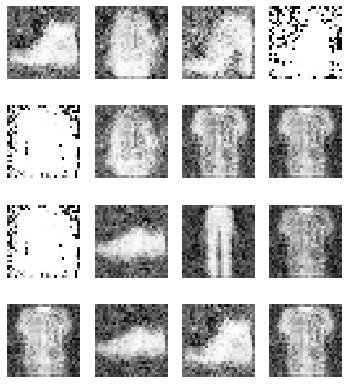

In [102]:
# Смотрим на результат
noise.data.normal_(0, 1)
noise = noise.to(device)
gen_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
fake = generatorCGAN(noise.detach(), gen_labels)
print(fake.shape)

show_pictures(fake)

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

Попробовали классический GAN, CGAN, и LSGAN. LSGAN показал себя лучше всего. Было замечено, что резульатат очень зависит от выбора лосс функции для обучения.


Спасибо за выполнение заданий!